<a href="https://colab.research.google.com/github/aneesh98/NeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!wget https://streetsla.lacity.org/sites/default/files/styles/image_hero_large/public/1stBridgeALT2.jpg

--2019-10-09 19:02:45--  https://streetsla.lacity.org/sites/default/files/styles/image_hero_large/public/1stBridgeALT2.jpg
Resolving streetsla.lacity.org (streetsla.lacity.org)... 52.244.230.41
Connecting to streetsla.lacity.org (streetsla.lacity.org)|52.244.230.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256374 (250K) [image/jpeg]
Saving to: ‘1stBridgeALT2.jpg’

1stBridgeALT2.jpg   100%[===================>] 250.37K   263KB/s    in 1.0s    

2019-10-09 19:02:47 (263 KB/s) - ‘1stBridgeALT2.jpg’ saved [256374/256374]



In [3]:
!wget https://render.fineartamerica.com/images/rendered/default/print/8.000/6.375/break/images/artworkimages/medium/1/abstract-nature-acrylic-painting-t-saranraj.jpg

--2019-10-09 19:02:29--  https://render.fineartamerica.com/images/rendered/default/print/8.000/6.375/break/images/artworkimages/medium/1/abstract-nature-acrylic-painting-t-saranraj.jpg
Resolving render.fineartamerica.com (render.fineartamerica.com)... 13.225.146.110, 13.225.146.15, 13.225.146.70, ...
Connecting to render.fineartamerica.com (render.fineartamerica.com)|13.225.146.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81306 (79K) [image/jpeg]
Saving to: ‘abstract-nature-acrylic-painting-t-saranraj.jpg.1’

abstract-nature-acr 100%[===================>]  79.40K   357KB/s    in 0.2s    

2019-10-09 19:02:30 (357 KB/s) - ‘abstract-nature-acrylic-painting-t-saranraj.jpg.1’ saved [81306/81306]



In [5]:
from keras.preprocessing.image import load_img, img_to_array
target_image_path = '/content/1stBridgeALT2.jpg'
style_reference_image_path = '/content/abstract-nature-acrylic-painting-t-saranraj.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int((width*img_height)/height)

Using TensorFlow backend.


In [0]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
  img = load_img(image_path, target_size = (img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x,0,255).astype('uint8')
  return x

In [7]:
from keras import backend as K
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis = 0)
model = vgg19.VGG19(input_tensor = input_tensor, weights = 'imagenet', include_top = False)
print('Model Loaded BKL')





80142336/80134624 [==============================] - 7s 0us/step






Model Loaded BKL


In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C))/(4*(channels**2) * (size**2))

def total_variation_loss(x):
  a = K.square( x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width -1, :])
  b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height -1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [9]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.015
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight/len(style_layers))*sl
loss += total_variation_weight*total_variation_loss(combination_image)

In [10]:
!pip install -U scipy==1.2.0

     |████████████████████████████████| 26.6MB 34.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [11]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])
class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
  
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator = Evaluator()
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time
result_prefix = 'my_result'
iterations = 20
# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
  fprime=evaluator.grads, maxfun=20)
  print('Current loss value:', min_val)
  # Save current generated image
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  imsave(fname, img)
  end_time = time.time()
  print('Image saved as', fname)
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Start of iteration 0
Current loss value: 2589166300.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 29s
Start of iteration 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 1219121000.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 21s
Start of iteration 2
Current loss value: 846005570.0
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 20s
Start of iteration 3
Current loss value: 673478000.0
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 20s
Start of iteration 4
Current loss value: 574321660.0
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 20s
Start of iteration 5
Current loss value: 515505060.0
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 20s
Start of iteration 6
Current loss value: 471694430.0
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 20s
Start of iteration 7
Current loss value: 428068800.0
Image saved as my_result_at_iteration_7.png
Iteration 7 completed in 20s
Start of iteration 8
Current loss value: 390342530.0
Image saved as my_result_at_iteration_8.png
Iteration 8 completed in 20s
Start of ite

Text(0.5, 0, 'Image Used for style transfer')

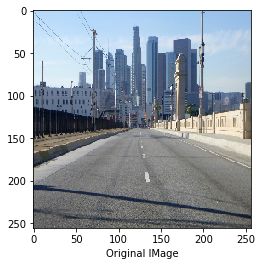

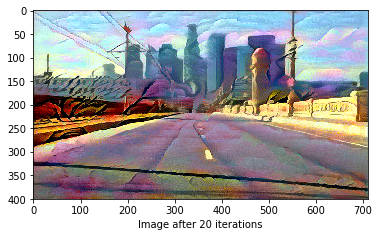

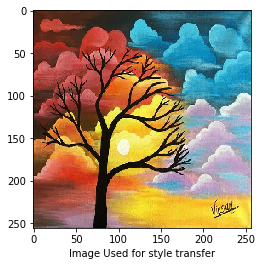

In [13]:
## RESULTS ##

import matplotlib.pyplot as plt
%matplotlib inline
org_img = load_img(target_image_path, target_size=(256, 256))
style_trans = load_img('my_result_at_iteration_19.png')
plt.imshow(org_img)
plt.xlabel("Original IMage")
plt.figure()
plt.imshow(style_trans)
plt.xlabel('Image after 20 iterations')
plt.figure()
plt.imshow(load_img(style_reference_image_path, target_size=(256, 256)))
plt.xlabel('Image Used for style transfer')